<a href="https://colab.research.google.com/github/MADHACKER85/stress-detection-using-ECG-signal/blob/main/TestPlatformTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import random
import json
import seaborn as sns
from tqdm import tqdm

# New Section

In [ ]:
from torch.nn.modules.activation import LeakyReLU
""" DNN Model """

def init_weight(m):
    """Initialization of the weights"""
    if isinstance(m,nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m, nn.BatchNorm1d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()

class ClassifierECG(nn.Module):
    """DNN model, see the model architecture in the report for more details"""
    def __init__(self, ngpu):
        super(ClassifierECG, self).__init__()
        self.ngpu = ngpu
        self.nnECG = nn.Sequential(
            nn.Linear(12,128,bias=True),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(128,64,bias=True),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(64,16,bias=True),
            nn.BatchNorm1d(16),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(16,4,bias=True),
            nn.BatchNorm1d(4),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(4,1,bias=True),
            nn.Sigmoid()
        )
        self.nnECG.apply(init_weight)

    def forward(self, input):
        return self.nnECG(input)

In [ ]:
ngpu = 1
net= ClassifierECG(ngpu).to('cpu')

In [ ]:
model_save_path = '/content/modelEcg.pth'  # or any other directory

net.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode if needed
net.eval()

print(f"Model loaded from {model_save_path}")

Model loaded from /content/modelEcg.pth


In [ ]:
class ds_wesad(Dataset):
    """ Define the Dataset object for the WESAD (feature vector;is_stressed(0/1);emotionnal_state(0;1;2;3)

    0 neutral
    1 stress
    2 amusement
    3 relax

    """
    def __init__(self, dic):
        self.samples = []
        self.dic=dic
        for i in range(0,len(dic["label"])):
            num=dic["label"][i]
            stress=num==2
            x=np.array(dic["features"][i])
            self.samples.append((x,int(stress),num))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, id):
        return self.samples[id]

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
g = torch.Generator()
g.manual_seed(1)

In [ ]:
num_workers = 2
batch_size = 32
ngpu = 1

f=open("test1.json")
data = json.load(f)
ds_test = ds_wesad(data)

dataloader_test = torch.utils.data.DataLoader(ds_test,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)

In [ ]:
def conf_mat(net,datal,trsh):
  """ Compute 2 confusion matrixes according to a dataloader and a threshold for state prediction (above the threshold the subject is
  under stress condition)

  2x2 confusion matrix : Stress and No stress as label for line and column
  3x4 confusion matrix : {Total ; Stress ; No stress} as label for the lines
                         {Neutral ; Stress ; Amusement; Meditation} as label for the columns
  """
  x=datal[0].float().to('cpu')
  y=net(x).view(-1)
  pred=(y>trsh).int()
  label=datal[1].float().to('cpu').view(-1).int()
  num=datal[2].float().to('cpu').int()
  comp=torch.eq(label,pred).int()
  mat_label=np.zeros((2,4))
  mat_nolbl=np.zeros((2,2))

  for i in range(0,4):
    tens=torch.where(num==i+1,1,0)
    numtot=torch.sum(tens).item()
    num_G=torch.sum(torch.where(torch.mul(tens,comp)==1,1,0)).item()

    if i ==1:
      mat_nolbl[0,0]+=num_G
      mat_nolbl[1,0]+=numtot-num_G
      mat_label[0,i]=num_G
      mat_label[1,i]=numtot-num_G

    else:
      mat_nolbl[1,1]+=num_G
      mat_nolbl[0,1]+=numtot-num_G
      mat_label[1,i]=num_G
      mat_label[0,i]=numtot-num_G


  return mat_label,mat_nolbl

accuracy 0.7381944444444445
precision 0.43121149897330596
recall 0.6774193548387096
F1score 0.5269761606022585


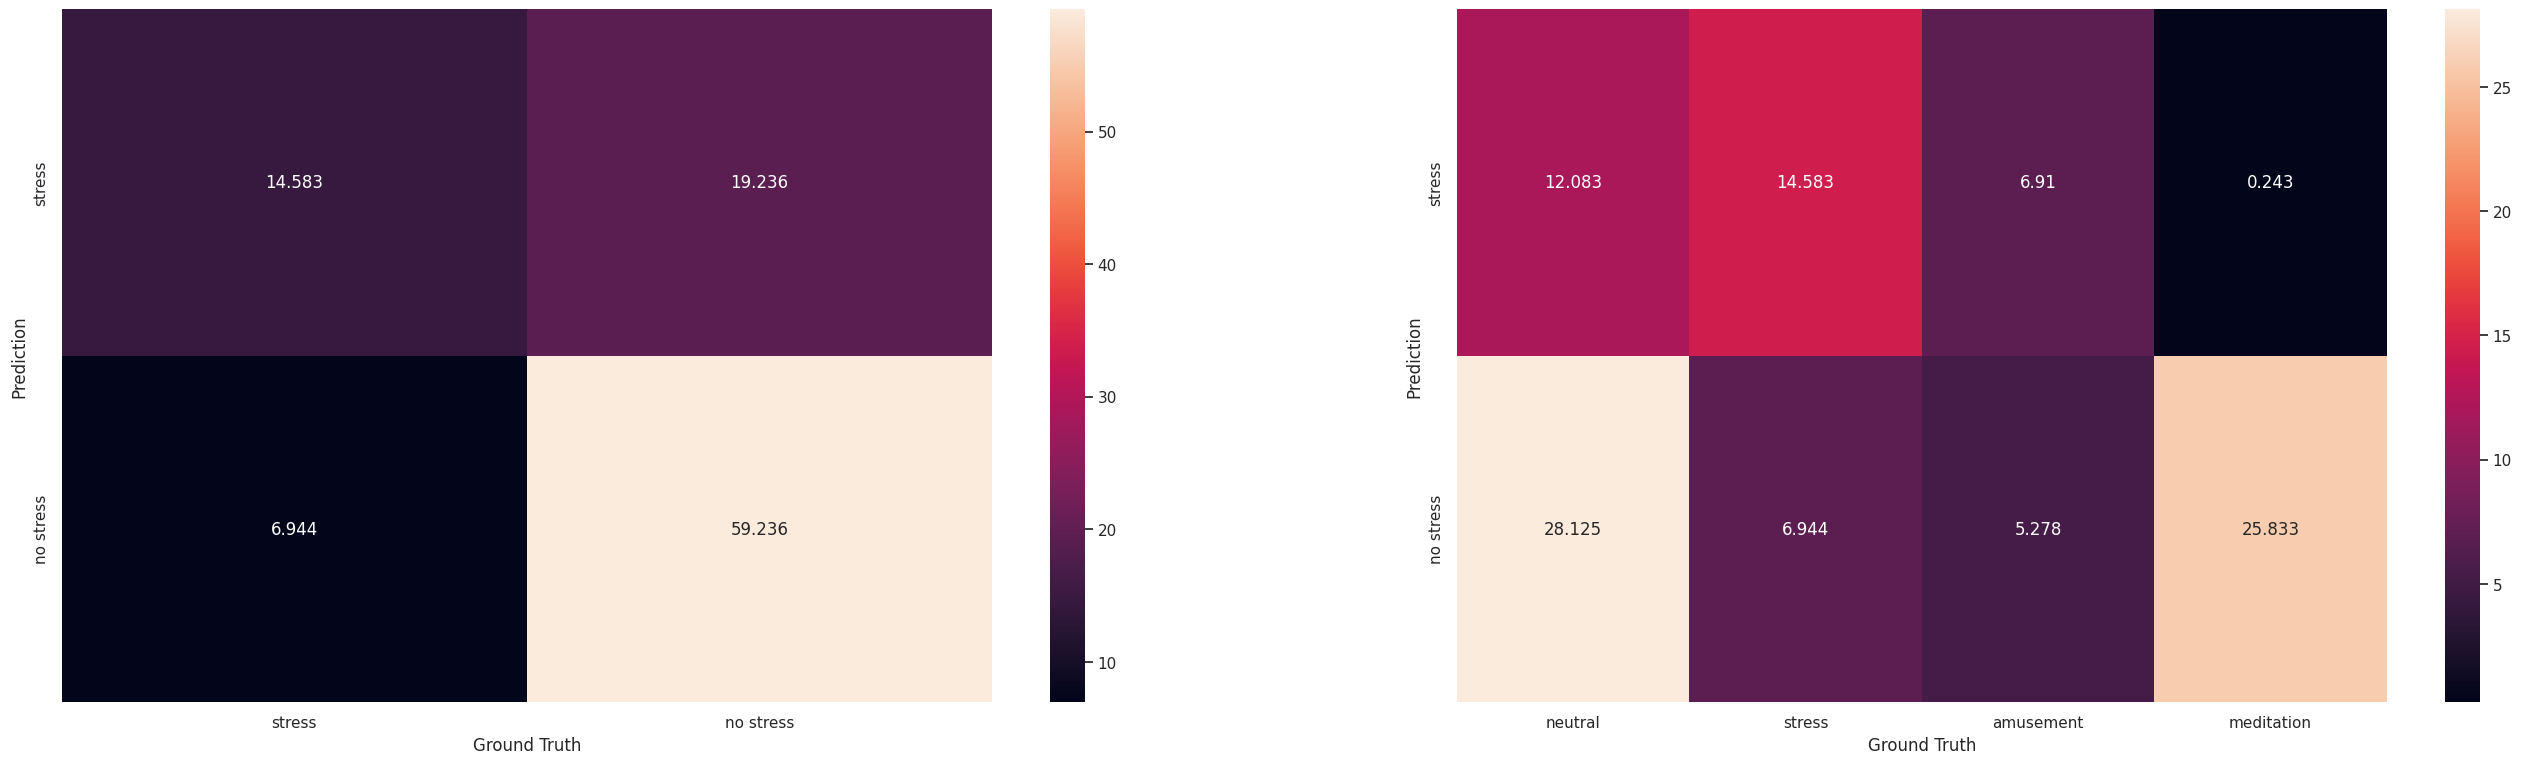

In [ ]:
# Results
Loss = []
trsh=0.5
net.eval()
confusionlabel=np.zeros((2,4))
confusion=np.zeros((2,2))
length_ds=0
for i, datal in enumerate(dataloader_test, 0):
      confusionlabelt,confusiont=conf_mat(net,datal,trsh)
      confusion+=confusiont
      confusionlabel+=confusionlabelt
      length_ds+=batch_size
x_axis_confl = ['neutral','stress','amusement','meditation'] # labels for x-axis
y_axis_confl = ['stress','no stress'] # labels for y-axis
x_axis_conf = ['stress','no stress']
y_axis_conf = ['stress','no stress']

# create seabvorn heatmap with required labels
confusion_annot=np.array([str(x) for x in np.round(100*confusion/length_ds,3).reshape(-1).tolist()]).reshape(confusion.shape)
confusionlabel_annot=np.array([str(x) for x in np.round(100*confusionlabel/length_ds,3).reshape(-1).tolist()]).reshape(confusionlabel.shape)
sns.set(rc={"figure.figsize":(15, 5)})
fig, axs = plt.subplots(ncols=2,figsize=(33,9))
sns.heatmap((100*confusion/length_ds), xticklabels=x_axis_conf, yticklabels=y_axis_conf,annot=confusion_annot,ax=axs[0],fmt = '')
axs[0].set_xlabel('Ground Truth')
axs[0].set_ylabel('Prediction')
sns.heatmap((100*confusionlabel/length_ds), xticklabels=x_axis_confl, yticklabels=y_axis_confl, annot=confusionlabel_annot,ax=axs[1],fmt = '')
axs[1].set_xlabel('Ground Truth')
axs[1].set_ylabel('Prediction')
TP=confusion[0,0]
TN=confusion[1,1]
FN=confusion[1,0]
FP=confusion[0,1]
acc=(TP+TN)/(TP+FP+FN+TN)
precision=TP/(TP+FP)
recall=TP/(TP+FN)
F1score=(2*recall*precision)/(recall+precision)
print("accuracy " +str(acc))
print("precision " +str(precision))
print("recall " +str(recall))
print("F1score "+str(F1score))

In [ ]:
import json
import torch
from collections import Counter

In [ ]:


# Step 1: Load the JSON file
def test_stress_level(test_file_path, id):
  with open(test_file_path, 'r') as file:
      data = json.load(file)  # Load the JSON data into a dictionary

  # Step 2: Extract the relevant data from the JSON
  features = data['features']  # Replace 'features' with the appropriate key in your JSON file

  # Step 3: Convert the extracted data to a PyTorch Tensor
  test_tensor = torch.tensor(features, dtype=torch.float32)

  # Check the shape of the tensor to ensure it matches the model's expected input


  # Ensure that the input tensor has the correct shape
  if len(test_tensor.shape) == 2:  # Expected shape is [batch_size, num_features]
      batch_size = test_tensor.shape[0]  # Get the batch size (number of samples)

  # Step 4: Forward pass the test tensor through the model to get predictions
  net.eval()  # Set the model to evaluation mode

  with torch.no_grad():
      output = net(test_tensor)  # Get the model's output (logits or probabilities) for the test data

      # Get the indices of the highest probability (the predicted class) for each sample in the batch
      predicted_class_indices = torch.argmax(output, dim=1).tolist()

  # Define the labels for each class
  class_labels = ['neutral', 'stress', 'amusement', 'meditation']

  # Output the predicted class labels for all samples in the batch
  predicted_class_labels = [class_labels[id] for idx in predicted_class_indices]

  # Count the occurrences of each predicted class
  class_count = Counter(predicted_class_labels)

  # Find the majority class (the class with the highest count)
  majority_class = class_count.most_common(1)[0][0]

  # Output the majority class
  print(f"The Precited stress of Patient {id} is: {majority_class}")


In [ ]:
test_stress_level('test1.json',1)
test_stress_level('test1.json',2)
test_stress_level('test1.json',3)

The Precited stress of Patient 1 is: stress
The Precited stress of Patient 2 is: amusement
The Precited stress of Patient 3 is: meditation


In [ ]:
def analyze_ecg_stress(model_path, test_file_path):
    try:
        # Load model
        print("Loading model...")
        model = ClassifierECG(ngpu=1).to('cpu')
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        model.eval()

        # Load data
        print("Loading test data...")
        with open(test_file_path, 'r') as file:
            data = json.load(file)

        # Validate and prepare features
        features = validate_data_format(data)

        # Normalize features
        features_mean = np.mean(features, axis=0)
        features_std = np.std(features, axis=0)
        features_normalized = (features - features_mean) / (features_std + 1e-8)

        # Convert to tensor
        test_tensor = torch.tensor(features_normalized, dtype=torch.float32)

        # Get predictions
        with torch.no_grad():
            outputs = model(test_tensor)
            probabilities = outputs.numpy()

            # Calculate average probability
            avg_prob = float(np.mean(probabilities))

            # Determine stress level
            if avg_prob >= 0.7:
                stress_level = "stress"
            elif avg_prob >= 0.5:
                stress_level = "neutral"
            elif avg_prob >= 0.3:
                stress_level = "amusement"
            else:
                stress_level = "meditation"

            print(f"The Predicted stress of Patient is: {stress_level}")
            return stress_level, avg_prob

    except Exception as e:
        print(f"Error in analysis: {str(e)}")
        return None, None

def main():
    # Set paths
    model_path = '/content/modelEcg.pth'
    test_file_path = 'test1.json'

    # Check if files exist
    if not os.path.exists(model_path):
        print(f"Error: Model file not found at {model_path}")
        return

    if not os.path.exists(test_file_path):
        print(f"Error: Test file not found at {test_file_path}")
        return

    # Test for single patient
    stress_level, probability = analyze_ecg_stress(model_path, test_file_path)

# Run the program
if __name__ == "__main__":
    main()

Loading model...
Loading test data...
Error in analysis: name 'validate_data_format' is not defined


In [ ]:
pip install gradio


In [ ]:
import gradio as gr
import torch
import torch.nn as nn
import numpy as np
import json
import os

class ClassifierECG(nn.Module):
    def __init__(self, ngpu):
        super(ClassifierECG, self).__init__()
        self.ngpu = ngpu
        self.nnECG = nn.Sequential(
            nn.Linear(12, 128, bias=True),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64, bias=True),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 16, bias=True),
            nn.BatchNorm1d(16),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 4, bias=True),
            nn.BatchNorm1d(4),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(4, 1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.nnECG(input)

def analyze_ecg_file(file_path):
    try:
        model_path = 'modelEcg.pth'
        model = ClassifierECG(ngpu=1).to('cpu')
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        model.eval()

        with open(file_path.name, 'r') as file:
            data = json.load(file)

        features = np.array(data['features'])
        features_mean = np.mean(features, axis=0)
        features_std = np.std(features, axis=0)
        features_normalized = (features - features_mean) / (features_std + 1e-8)
        test_tensor = torch.tensor(features_normalized, dtype=torch.float32)

        with torch.no_grad():
            outputs = model(test_tensor)
            probabilities = outputs.numpy()
            avg_prob = float(np.mean(probabilities))

            if avg_prob >= 0.7:
                stress_level = "Stress"
                color = "🔴"
            elif avg_prob >= 0.5:
                stress_level = "Neutral"
                color = "🟡"
            elif avg_prob >= 0.3:
                stress_level = "Amusement"
                color = "🟢"
            else:
                stress_level = "Meditation"
                color = "🔵"

            return f"""
            {color} Analysis Results {color}
            ----------------------
            State: {stress_level}
            """

    except Exception as e:
        return f"❌ Error: {str(e)}"

with gr.Blocks(css="footer {display: none}") as demo:
    gr.Markdown("# 💓 ECG Stress Analysis")

    with gr.Row():
        file_input = gr.File(
            label="📁 Upload ECG Data File",
            file_types=[".json"]
        )

    with gr.Row():
        output = gr.Textbox(
            label="📊 Results",
            lines=3
        )

    file_input.change(
        fn=analyze_ecg_file,
        inputs=file_input,
        outputs=output
    )

if __name__ == "__main__":
    demo.launch(
        show_api=False,
        show_error=False,
        share=True
    )

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://48325d456bce5f9404.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import torch
import torch.nn as nn
import numpy as np
import json

class ClassifierECG(nn.Module):
    def __init__(self, ngpu):
        super(ClassifierECG, self).__init__()
        self.ngpu = ngpu
        self.nnECG = nn.Sequential(
            nn.Linear(12, 128, bias=True),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64, bias=True),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 16, bias=True),
            nn.BatchNorm1d(16),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 4, bias=True),
            nn.BatchNorm1d(4),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(4, 1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.nnECG(input)

# Load model once globally to avoid reloading on every call
model_path = 'modelEcg.pth'
net = ClassifierECG(ngpu=1).to('cpu')
net.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
net.eval()

# Breathing exercise game HTML + JS
breathing_game_html = """
<div style="text-align:center; font-family:sans-serif;">
  <h3>Breathing Exercise</h3>
  <p>Follow the circle to breathe in and out slowly.</p>
  <svg width="200" height="200">
    <circle id="circle" cx="100" cy="100" r="50" fill="#4CAF50" opacity="0.7"/>
  </svg>
  <p id="instruction">Breathe in...</p>
</div>
<script>
  let circle = document.getElementById('circle');
  let instruction = document.getElementById('instruction');
  let grow = true;
  let radius = 50;
  setInterval(() => {
    if(grow) {
      radius += 1;
      instruction.textContent = "Breathe in...";
      if(radius >= 80) grow = false;
    } else {
      radius -= 1;
      instruction.textContent = "Breathe out...";
      if(radius <= 50) grow = true;
    }
    circle.setAttribute('r', radius);
  }, 100);
</script>
"""
# Interactive Catch Game HTML + JS
interactive_game_html = """
<div style="text-align:center; font-family:sans-serif;">
  <h3>Catch the Circles Game</h3>
  <p>Move your mouse left and right to catch the falling circles!</p>
  <canvas id="gameCanvas" width="400" height="300" style="border:1px solid #000000; background:#f0f8ff;"></canvas>
  <p>Score: <span id="score">0</span></p>
</div>

<script>
  const canvas = document.getElementById('gameCanvas');
  const ctx = canvas.getContext('2d');
  const paddleWidth = 80;
  const paddleHeight = 15;
  let paddleX = (canvas.width - paddleWidth) / 2;

  let score = 0;
  let circles = [];
  let circleRadius = 15;
  let gameOver = false;

  // Create circles periodically
  function createCircle() {
    const x = Math.random() * (canvas.width - 2 * circleRadius) + circleRadius;
    circles.push({x: x, y: 0, speed: 2 + Math.random() * 2});
  }

  // Draw paddle
  function drawPaddle() {
    ctx.fillStyle = '#007ACC';
    ctx.fillRect(paddleX, canvas.height - paddleHeight - 10, paddleWidth, paddleHeight);
  }

  // Draw circles
  function drawCircles() {
    ctx.fillStyle = '#FF6347';
    circles.forEach(circle => {
      ctx.beginPath();
      ctx.arc(circle.x, circle.y, circleRadius, 0, Math.PI * 2);
      ctx.fill();
    });
  }

  // Update circle positions
  function updateCircles() {
    circles.forEach((circle, index) => {
      circle.y += circle.speed;
      // Check if caught by paddle
      if (
        circle.y + circleRadius >= canvas.height - paddleHeight - 10 &&
        circle.x > paddleX &&
        circle.x < paddleX + paddleWidth
      ) {
        score++;
        document.getElementById('score').textContent = score;
        circles.splice(index, 1);
      }
      // Remove circles that fall below canvas (missed)
      else if (circle.y - circleRadius > canvas.height) {
        circles.splice(index, 1);
      }
    });
  }

  // Clear canvas
  function clearCanvas() {
    ctx.clearRect(0, 0, canvas.width, canvas.height);
  }

  // Game loop
  function gameLoop() {
    if (gameOver) return;
    clearCanvas();
    drawPaddle();
    drawCircles();
    updateCircles();
    requestAnimationFrame(gameLoop);
  }

  // Paddle follows mouse
  canvas.addEventListener('mousemove', function(event) {
    const rect = canvas.getBoundingClientRect();
    paddleX = event.clientX - rect.left - paddleWidth / 2;
    if (paddleX < 0) paddleX = 0;
    if (paddleX + paddleWidth > canvas.width) paddleX = canvas.width - paddleWidth;
  });

  // Start the game
  gameLoop();
  setInterval(createCircle, 1000);
</script>
"""

# Replace the previous show_breathing_game function with this:
def show_interactive_game():
    return interactive_game_html


def analyze_ecg_file(file_path):
    try:
        with open(file_path.name, 'r') as file:
            data = json.load(file)

        features = np.array(data['features'])
        features_mean = np.mean(features, axis=0)
        features_std = np.std(features, axis=0)
        features_normalized = (features - features_mean) / (features_std + 1e-8)
        test_tensor = torch.tensor(features_normalized, dtype=torch.float32)

        with torch.no_grad():
            outputs = net(test_tensor)
            probabilities = outputs.numpy()
            avg_prob = float(np.mean(probabilities))

        if avg_prob >= 0.7:
            stress_level = "Stress"
            color = "🔴"
        elif avg_prob >= 0.5:
            stress_level = "Neutral"
            color = "🟡"
        elif avg_prob >= 0.3:
            stress_level = "Amusement"
            color = "🟢"
        else:
            stress_level = "Meditation"
            color = "🔵"

        message = f"""
{color} Analysis Results {color}
----------------------
State: {stress_level}
Average Stress Probability: {avg_prob:.2f}
"""

        # Determine if stress-relief game button should be shown
        show_game_button = avg_prob >= 0.5  # Show button for Stress or Neutral states

        return message, gr.update(visible=show_game_button), ""

    except Exception as e:
        return f"❌ Error: {str(e)}", gr.update(visible=False), ""

def show_breathing_game():
    return interactive_game_html

with gr.Blocks(css="footer {display: none}") as demo:
    gr.Markdown("# 💓 ECG Stress Analysis")

    with gr.Row():
        file_input = gr.File(
            label="📁 Upload ECG Data File",
            file_types=[".json"]
        )

    with gr.Row():
        output = gr.Textbox(
            label="📊 Results",
            lines=6
        )

    game_button = gr.Button("Play Stress Relief Game", visible=False)
    game_html = gr.HTML()

    file_input.change(
        fn=analyze_ecg_file,
        inputs=file_input,
        outputs=[output, game_button, game_html]
    )

    game_button.click(
        fn=show_breathing_game,
        inputs=None,
        outputs=game_html
    )

if __name__ == "__main__":
    demo.launch(
        show_api=False,
        show_error=False,
        share=True
    )


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8861ab3544b1d3edce.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import torch
import torch.nn as nn
import numpy as np
import json

# Your original model definition
class ClassifierECG(nn.Module):
    def __init__(self, ngpu):
        super(ClassifierECG, self).__init__()
        self.ngpu = ngpu
        self.nnECG = nn.Sequential(
            nn.Linear(12, 128, bias=True),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64, bias=True),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 16, bias=True),
            nn.BatchNorm1d(16),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 4, bias=True),
            nn.BatchNorm1d(4),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(4, 1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.nnECG(input)

# Load model once globally
model_path = 'modelEcg.pth'
net = ClassifierECG(ngpu=1).to('cpu')
net.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
net.eval()

# Breathing exercise game with slow animation and 2-minute timer
breathing_game_html = """
<div style="text-align:center; font-family:sans-serif; margin-top:20px;">
  <h3>Breathing Exercise</h3>
  <p>Follow the circle to breathe in and out slowly.</p>
  <svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 200 200" width="200" height="200" style="display:block; margin:auto;">
    <circle id="breath-circle" cx="100" cy="100" r="50" fill="#4CAF50" opacity="0.7" style="animation: breathe 8s ease-in-out infinite;" />
    <style>
      @keyframes breathe {
        0%, 100% { transform: scale(1); }
        50% { transform: scale(1.6); }
      }
    </style>
  </svg>
  <p id="instruction" style="font-weight:bold; font-size:18px;">Breathe in...</p>
  <p id="timer" style="font-weight:bold; font-size:20px; margin-top:10px;">02:00</p>
  <p id="complete-msg" style="font-weight:bold; font-size:20px; color:green; display:none;">Session Complete! Well done.</p>
</div>

<script>
  (function(){
    const circle = document.getElementById('breath-circle');
    const instruction = document.getElementById('instruction');
    const timerDisplay = document.getElementById('timer');
    const completeMsg = document.getElementById('complete-msg');

    let grow = true;
    let animationDuration = 8000; // 8 seconds full cycle
    let halfCycle = animationDuration / 2;
    let startTime = null;
    let animationFrameId = null;

    // Timer variables
    let totalSeconds = 120; // 2 minutes
    let timerInterval = null;

    // Update instruction text synced with animation
    function updateInstruction(timestamp) {
      if (!startTime) startTime = timestamp;
      let elapsed = (timestamp - startTime) % animationDuration;

      if (elapsed < halfCycle) {
        instruction.textContent = "Breathe in...";
      } else {
        instruction.textContent = "Breathe out...";
      }
      animationFrameId = requestAnimationFrame(updateInstruction);
    }

    // Timer countdown function
    function startTimer() {
      let remaining = totalSeconds;
      timerDisplay.textContent = formatTime(remaining);

      timerInterval = setInterval(() => {
        remaining--;
        timerDisplay.textContent = formatTime(remaining);
        if (remaining <= 0) {
          clearInterval(timerInterval);
          completeSession();
        }
      }, 1000);
    }

    // Format seconds to MM:SS
    function formatTime(seconds) {
      let m = Math.floor(seconds / 60);
      let s = seconds % 60;
      return `${m.toString().padStart(2,'0')}:${s.toString().padStart(2,'0')}`;
    }

    // Stop animation and show completion message
    function completeSession() {
      cancelAnimationFrame(animationFrameId);
      instruction.style.display = 'none';
      circle.style.animationPlayState = 'paused';
      timerDisplay.style.display = 'none';
      completeMsg.style.display = 'block';
    }

    // Start everything once page loads
    window.onload = () => {
      circle.style.animationPlayState = 'running';
      animationFrameId = requestAnimationFrame(updateInstruction);
      startTimer();
    };
  })();
</script>
"""

def analyze_ecg_file(file_path):
    try:
        with open(file_path.name, 'r') as file:
            data = json.load(file)

        features = np.array(data['features'])
        features_mean = np.mean(features, axis=0)
        features_std = np.std(features, axis=0)
        features_normalized = (features - features_mean) / (features_std + 1e-8)
        test_tensor = torch.tensor(features_normalized, dtype=torch.float32)

        with torch.no_grad():
            outputs = net(test_tensor)
            probabilities = outputs.numpy()
            avg_prob = float(np.mean(probabilities))

        if avg_prob >= 0.7:
            stress_level = "Stress"
            color = "🔴"
        elif avg_prob >= 0.5:
            stress_level = "Neutral"
            color = "🟡"
        elif avg_prob >= 0.3:
            stress_level = "Amusement"
            color = "🟢"
        else:
            stress_level = "Meditation"
            color = "🔵"

        message = f"""
{color} Analysis Results {color}
----------------------
State: {stress_level}
Average Stress Probability: {avg_prob:.2f}
"""

        show_game_button = avg_prob >= 0.5

        return message, gr.update(visible=show_game_button), ""

    except Exception as e:
        return f"❌ Error: {str(e)}", gr.update(visible=False), ""

def show_breathing_game():
    return breathing_game_html

with gr.Blocks(css="footer {display: none}") as demo:
    gr.Markdown("# 💓 ECG Stress Analysis with Breathing Exercise")

    with gr.Row():
        file_input = gr.File(
            label="📁 Upload ECG Data File",
            file_types=[".json"]
        )

    with gr.Row():
        output = gr.Textbox(
            label="📊 Results",
            lines=6
        )

    game_button = gr.Button("Play Breathing Exercise", visible=False)
    game_html = gr.HTML()

    file_input.change(
        fn=analyze_ecg_file,
        inputs=file_input,
        outputs=[output, game_button, game_html]
    )

    game_button.click(
        fn=show_breathing_game,
        inputs=None,
        outputs=game_html
    )

if __name__ == "__main__":
    demo.launch(
        show_api=False,
        show_error=False,
        share=True
    )


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c83fb01e726ccc2c20.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
